In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline
%matplotlib qt

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


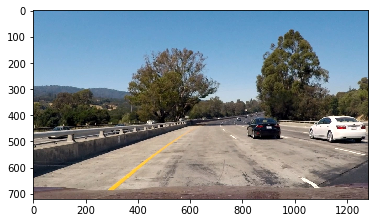

In [2]:
image = mpimg.imread('test_images/test1.jpg')/255
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.left_fitx = None
        self.right_fitx = None
        self.counter = 0
        self.reset_counter = 0

line = Line()

In [4]:
def hls_conversion(image):

    """
    creating the h, l and s channels of hls image from an image
    
    inputs:
        image
    outputs:
        hls
        h_channel
        l_channel
        s_channel
    """
#outimageHSV = np.uint8(outimageHSV)
#outimageBGR = cv2.cvtColor(outimageHSV, cv2.COLOR_HSV2BGR)

    img = np.copy(image)
    img = np.uint8(img)
    #plt.imshow(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    return (hls, h_channel, l_channel, s_channel)

In [5]:
def Camera_calib(All_Chess_images):
    """"
    
    inputs:
    
    outputs:
        corners
        ret
        mtx
        dist
        rvecs
        tvecs
    """
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    #Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    #images = glob.glob('../camera_cal/calibration*.jpg')
    img_chessboard = []
    
    for chess_image in All_Chess_images:
        image_chess = mpimg.imread(chess_image)
        gray = cv2.cvtColor(image_chess,cv2.COLOR_BGR2GRAY)

        #Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        #print(ret)
        #If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
        #Draw and display the corners
        #img_chessboard = cv2.drawChessboardCorners(image_chess, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    
    return img_chessboard, corners, ret, mtx, dist, rvecs, tvecs
#img_chessboard, corners, ret, mtx, dist, rvecs, tvecs = Camera_calib()
#print(img)
#plt.imshow(img_chessboard)

In [6]:
def undistort (img, mtx, dist):

    """
    
    inputs:
    
    outputs:
        dst
    """
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


In [7]:
def find_sobels(image, l_channel, s_channel, s_thresh=(110, 255), sx_thresh=(0, 255), sy_thresh=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2), sobel_kernel = 3):
    """
    applying a color threshold in the HLS color space to detect the lanes

    inputs:
        image
        l_channel
        s_channel
        s_thresh
        sx_thresh
        sy_thresh
        mag_thresh
        dir_thresh
    outputs:
        color_binary_x
        color_binary_y
        mag_binary
        direction_binary
        s_binary_color
    """
    #img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.uint8(image)
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_x = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, sobel_kernel) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from horizontal
    scaled_sobel_y = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    abs_sobel = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    mag_sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    scale_factor = np.max(mag_sobel)/255 
    gradmag = (mag_sobel/scale_factor).astype(np.uint8)
    
    abs_mag_sobel = np.absolute(mag_sobel)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel_x)
    sxbinary[(scaled_sobel_x >= sx_thresh[0]) & (scaled_sobel_x <= sx_thresh[1])] = 1
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobel_y)
    sybinary[(scaled_sobel_y >= sy_thresh[0]) & (scaled_sobel_y <= sy_thresh[1])] = 1
    
    # Threshold color channel
    s_binary_color = np.zeros_like(s_channel)
    s_binary_color[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #color_binary_x = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    #color_binary_y = np.dstack(( np.zeros_like(sybinary), sybinary, s_binary)) * 255
    
    scaled_magnitude = np.uint8(255*abs_mag_sobel/np.max(abs_mag_sobel))
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    
    direction_binary = np.zeros_like(arctan)
    direction_binary[(arctan >= dir_thresh[0]) & (arctan <= dir_thresh[1])] = 1
    
    #return color_binary_x, color_binary_y, mag_binary, direction_binary
    return sxbinary, sybinary, mag_binary, direction_binary, s_binary_color


In [8]:
def combined_sobel(sxbinary, sybinary, mag_binary, direction_binary, s_binary_color):

    """
    combination of diferent gradient measurements
    
    inputs:
        sxbinary
        sybinary
        mag_binary
        direction_binary
        s_binary_color
    outputs:
        combined_all
    """
    
    combined_no_col = np.zeros_like(direction_binary)
    combined_no_col[((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (direction_binary == 1))] = 1
    
    combined_all = np.zeros_like(combined_no_col)
    combined_all[(combined_no_col == 1) | (s_binary_color == 1)] = 1
    
    return combined_all

In [9]:
def image_tansformation(image, image_size, corners):

    """
    inputs:
        image
        image_size
        corners
    outputs:
        warped
        ransform_matrix
    """
    #defining the corner of source region
    #print(image_size)
    offset = 100
    
    src_corner_ul = [590, 450]
    src_corner_ur = [700, 450]
    src_cornre_ll = [200, 670]
    src_corner_lr = [1100, 700]

    #src_corner_ul = [image_size[0]//2, 450]
    #src_corner_ur = [(image_size[0]//2)+offset, 450]
    #src_cornre_ll = [200, image_size[1]]
    #src_corner_lr = [1000, image_size[1]]
    #print((image_size[0]//2)+offset)
    dst_corner_ul = [200, 0]
    dst_corner_ur = [1000, 0]
    dst_corner_ll = [200, 700]
    dst_corner_lr = [1000, 700]

    src_region = np.float32([src_corner_ul, src_cornre_ll, src_corner_ur, src_corner_lr])
    dst_region = np.float32([dst_corner_ul, dst_corner_ll, dst_corner_ur, dst_corner_lr])
    #print(src_region, 'src')
    #print(dst_region, 'dst')
    
    transform_matrix = []
    transform_matrix = cv2.getPerspectiveTransform(src_region, dst_region)
    warped = []
    warped = cv2.warpPerspective(image, transform_matrix, image_size)
    
    
    return (warped, transform_matrix)

#corners, ret, mtx, dist, rvecs, tvecs, img_chessboard = Camera_calib()
#image_size = (image.shape[1], image.shape[0])    
#warped, transform_matrix = image_tansformation(image, image_size, corners)  
#print(transform_matrix)
#f, (axim1, axim2) = plt.subplots(1,2, figsize=(20,10))
#axim1.imshow(image)
#axim2.imshow(warped)
#plt.imshow(warped)

In [10]:
def hist(warped_trans):
    """
    calculating the histogram of image
    
    inputs:
        warped_trans
    outputs:
        histogram
        leftx_current
        rightx_current
    """
    #histogram = np.sum(warped_trans[warped_trans.shape[0]//2:,:], axis=0)
    bottom_half = warped_trans[warped_trans.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    #plt.plot(histogram)
    
    hist_mp = np.int(histogram.shape[0]//2)
    leftx_current = np.argmax(histogram[:hist_mp])
    rightx_current = np.argmax(histogram[hist_mp:]) + hist_mp
    
    return histogram, leftx_current, rightx_current



In [11]:
def find_lane_pixle(out_img, binary_warped, leftx_current, rightx_current):

    """
    
    inputs:
        out_img
        binary_warped
        leftx_current
        rightx_current
    outputs:
        leftx
        lefty
        rightx
        righty
    """
    
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return leftx, lefty, rightx, righty, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fit, right_fit


In [12]:
def locate_line_further(left_fit, right_fit, binary_warped):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
     
    return left_fit_new, right_fit_new


In [13]:
def is_line_valid(left_fit, right_fit):
    
    #Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        line_valid = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 150 and delta_lines <=450: 
            line_valid = True
        else:
            line_valid = False
        
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        left = 2*left_fit[0]*360+left_fit[1]
        right = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(left-right)

        #Check if lines are parallel at the middle
        if delta_slope_mid <= 0.1:
            line_valid = True
        else:
            line_valid = False
            
    return line_valid


In [14]:
def find_line(warped_trans, leftx_current, rightx_current):

    out_img = np.dstack((warped_trans, warped_trans, warped_trans))*255
    ploty = np.linspace(0, warped_trans.shape[0]-1, warped_trans.shape[0] )
    #if line.counter == 0:
    leftx, lefty, rightx, righty, nonzerox, nonzeroy, line.left_lane_inds, line.right_lane_inds, line.left_fit, line.right_fit = find_lane_pixle(out_img, warped_trans, leftx_current, rightx_current)
    #out_img, leftx, lefty, rightx, righty, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fit, right_fit
    #else:
    if line.counter != 0:
        line.left_fit, line.right_fit  = locate_line_further(line.left_fit, line.right_fit, warped_trans)
        
    line_valid = is_line_valid(line.left_fit, line.right_fit)
    
    if line_valid == True:        
        line.last_left, line.last_right = line.left_fit, line.right_fit        
        line.counter += 1
        line.reset_counter = 0
    else:
        if line.reset_counter > 4:
            leftx, lefty, rightx, righty, nonzerox, nonzeroy, line.left_lane_inds, line.right_lane_inds, line.left_fit, line.right_fit = find_lane_pixle(out_img, warped_trans, leftx_current, rightx_current)
            line.reset_counter = 0
        else:
            line.left_fit, line.right_fit = line.last_left, line.last_right
        line.reset_counter += 1
    try:
        line.left_fitx = line.left_fit[0]*ploty**2 + line.left_fit[1]*ploty + line.left_fit[2]
        line.right_fitx = line.right_fit[0]*ploty**2 + line.right_fit[1]*ploty + line.right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line for this image!')
        
        line.left_fitx = 1*ploty**2 + 1*ploty
        line.right_fitx = 1*ploty**2 + 1*ploty
    
    return out_img, ploty, leftx, lefty, rightx, righty, line.left_fit, line.right_fit, line.left_fitx, line.right_fitx


In [15]:
def curvature_calc_txt(binary_warped, ploty, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix, leftx_current, rightx_current, left_fitx, right_fitx):

    """
    inputs:
        binary_warped
        ploty
        leftx
        lefty
        rightx
        righty
        xm_per_pix
        ym_per_pix
    outputs:
        left_curverad
        right_curverad
        y_val
    
    """
    
    left_fit_rad = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_rad = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1+(2*left_fit_rad[0]*y_eval*ym_per_pix + left_fit_rad[1])**2)**(3/2))/np.absolute(2*left_fit_rad[0])  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_rad[0]*y_eval*ym_per_pix + right_fit_rad[1])**2)**(3/2))/np.absolute(2*right_fit_rad[0])  ## Implement the calculation of the right line here
    
    left_lane_bottom = leftx_current
    right_lane_bottom = rightx_current
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = binary_warped.shape[1]//2
    #print(center_image)
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center_txt = "Vehicle is {:.2f}m {}".format(center, position)
    
    #return left_curverad, right_curverad, left_fit, right_fit, y_eval
    return left_curverad, right_curverad, center_txt



In [16]:
def draw_on_image(ploty, undist_img, warped_trans, left_fitx, right_fitx, transform_matrix, left_curverad, right_curverad, center_txt):
    
    """
    inputs:
        ploty
        undist_img
        warped_trans
        left_fitx
        right_fitx
        transform_matrix
        left_curverad
        right_curverad
        center_txt
    outputs:
        final_img
    """

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_trans).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #try:
    #    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
    #    print('The function failed to fit a line!')
    #    left_fitx = 1*ploty**2 + 1*ploty
    #    right_fitx = 1*ploty**2 + 1*ploty
        
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(transform_matrix)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    final_img = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    cv2.putText(final_img, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_img, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_img, '{}'.format(center_txt), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
        
    return final_img


In [17]:

def myPipeline (binary_warped, image_size):
    
    """
    
    inputs:
        binary_warped
    outputs:
        out_img
        warped_trans
        transform_matrix
        ploty, left_curverad
        right_curverad
        left_fitx
        right_fitx
        center_txt
        
    """
    
    #calibration, undistortion
    All_Chess_images = glob.glob('./camera_cal/calibration*.jpg')
    img_chessboard, corners, ret, mtx, dist, rvecs, tvecs = Camera_calib(All_Chess_images)
    image_undistored = undistort (binary_warped, mtx, dist) #* 255
    
    # color transformation
    hls, h_channel, l_channel, s_channel = hls_conversion(image_undistored)
    sxbinary, sybinary, mag_binary, direction_binary, s_binary_color = find_sobels(image_undistored, l_channel, s_channel, s_thresh=(170, 255), sx_thresh=(20, 100), sy_thresh=(20, 100), mag_thresh=(20, 100), dir_thresh=(0.7, 1.4), sobel_kernel = 3)
    #binary_image = combined_sobel(color_binary_x, color_binary_y, mag_binary, direction_binary)
    combined_all = combined_sobel(sxbinary, sybinary, mag_binary, direction_binary, s_binary_color)

    #birds-eye view and histogram
    warped_trans, transform_matrix = image_tansformation(combined_all, image_size, corners)
    hist_image, leftx_current, rightx_current = hist(warped_trans)
    
    
    out_img, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx = find_line(warped_trans, leftx_current, rightx_current)
    
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    image_matrix = []
    left_curverad, right_curverad, center_txt = curvature_calc_txt(out_img, ploty, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix, leftx_current, rightx_current, left_fitx, right_fitx)
    image_matrix.append(out_img)
    return out_img, image_undistored, ploty, warped_trans, transform_matrix, ploty, left_curverad, right_curverad, left_fit, right_fit, center_txt, left_fitx, right_fitx

#image = mpimg.imread('test_images/test1.jpg')
#out_img, image_undistored, warped_trans, transform_matrix, ploty, left_curverad, right_curverad, left_fitx, right_fitx, center_txt = myPipeline(image)
#plt.plot(right_fitx)
#print(transform_matrix)


In [18]:
def image_process(image):
    
    """
    
    inputs:
        image_name
    outputs:
        final_img
    """

    image_size = (image.shape[1], image.shape[0])
    out_img, image_undistored, ploty, warped_trans, transform_matrix, ploty, left_curverad, right_curverad, left_fit, right_fit, center_txt, left_fitx, right_fitx = myPipeline(image, image_size)
    image_undistored = image_undistored
    final_img = draw_on_image(ploty, image_undistored, warped_trans, left_fitx, right_fitx, transform_matrix, left_curverad, right_curverad, center_txt)

    return final_img #final_image_uint8


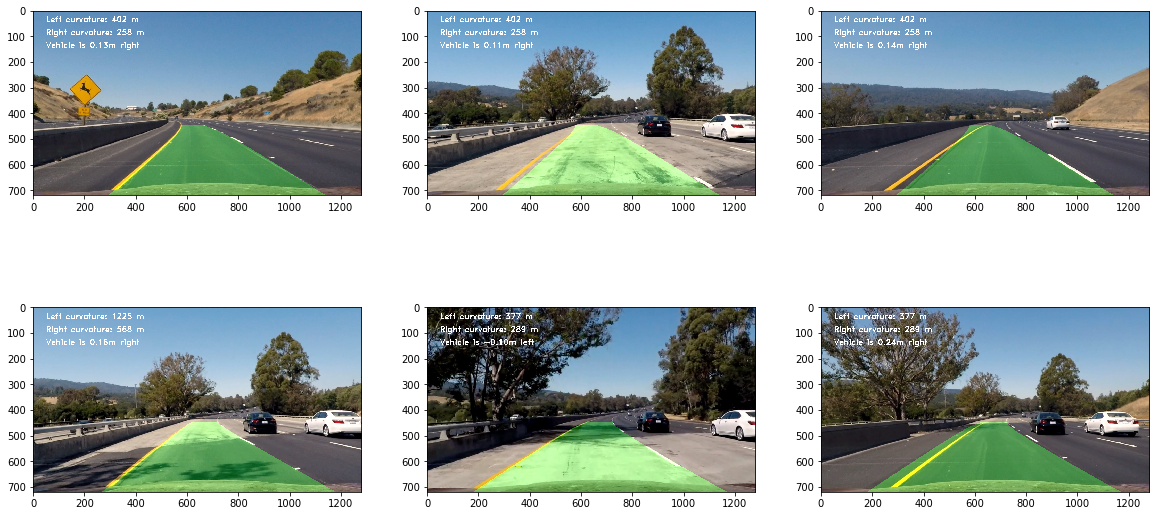

In [19]:
image_adress = 'test_images'
image_array = ['test2.jpg', 'test1.jpg','test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
#image_array = ['test2.jpg', 'test1.jpg']
image_matrix = []
f, ((axim1, axim2, axim3), (axim4, axim5, axim6)) = plt.subplots(2,3, figsize=(20,10))
axim = [axim1, axim2, axim3, axim4, axim5, axim6]
img_idx = 0
for image_file in image_array:
    image_name = image_adress+'/'+image_file
    image = mpimg.imread(image_name)
    final_img = image_process(image)
    
    axim[img_idx].imshow(final_img)
    axim[img_idx].set_title = image_name
    img_idx +=1

In [20]:

white_output = "output_video/project_video.mp4"
clip1 = VideoFileClip("project_video.mp4")#.subclip(41, 43)
#clip1 = VideoFileClip(input_video).subclip(0,5)\
white_clip = clip1.fl_image(image_process)
%time white_clip.write_videofile(white_output, audio=False)


t:   0%|          | 2/1260 [00:04<47:15,  2.25s/it, now=None]

Moviepy - Building video output_video/project_video.mp4.
Moviepy - Writing video output_video/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_video/project_video.mp4
CPU times: user 1h 25min 32s, sys: 6min 53s, total: 1h 32min 25s
Wall time: 1h 32min 28s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
